# Guillaume Payeur (260929164)

#### Note to grader: all the code explanations and figures are included in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
from scipy import integrate
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rcParams.update({"text.usetex": True})

# Q1

The function we have to integrate to get the electric field due to a shell of Radius $R$ a distance $z$ from the center is (up to a constant)
\begin{align}
    f(z) = \frac{z-z'}{(R^2-2zz'+z^2)^{3/2}}
\end{align}
So,
\begin{align}
    \boxed{E(z) = \int_{-R}^{R}\frac{z-z'}{(R^2-2zz'+z^2)^{3/2}}dz'}
\end{align}
Note that at $z=R$, the integral is
\begin{align}
    E(R) = \int_{-R}^{R}\frac{R-z'}{(2R^2-2Rz')^{3/2}}dz'
\end{align}
and we see that at $z'=R$, the integrand is not defined. This is a problem for an integrator like the one we wrote in class. Quad is able to work around that, though. In what follows I avoid the point $z=R$ for that reason.

In [2]:
# variable step size integrator adapted from the one written in class
def my_integrate(f,a,b,tol):
    # Integrating with 3 point and 5 point Simpson's rule
    x = np.linspace(a,b,5)
    y = f(x)
    int_3 = (x[-1]-x[0])/6*(y[0]+4*y[2]+y[4])
    int_5 = (x[-1]-x[0])/12*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])
    # if approximate error < tol, return the result, else split the 
    # integral in 2
    if np.abs(int_3-int_5)<tol:
        return int_5
    int_left = my_integrate(f,a,(a+b)/2,tol/2)
    int_right = my_integrate(f,(a+b)/2,b,tol/2)
    return int_left + int_right

# function to generate the function to be integrate (the electric field 
# of charged rings)
def gen_f(z,R):
    def f(zprime):
        return (z-zprime)/((R**2-2*z*zprime+z**2)**(3/2))
    return f

Taking many values of $z$, fixing $R=1$, and plotting the electric field as a function of $z$

In [3]:
R=1
z_array = np.linspace(-2*R,2*R,500)
E_array = np.zeros_like(z_array)
E_array_quad = np.zeros_like(z_array)
for i in range(500):
    f = gen_f(z_array[i],R)
    E_array[i] = my_integrate(f,-R,R,1e-5)
    E_array_quad[i] = integrate.quad(f,-R,R)[0]

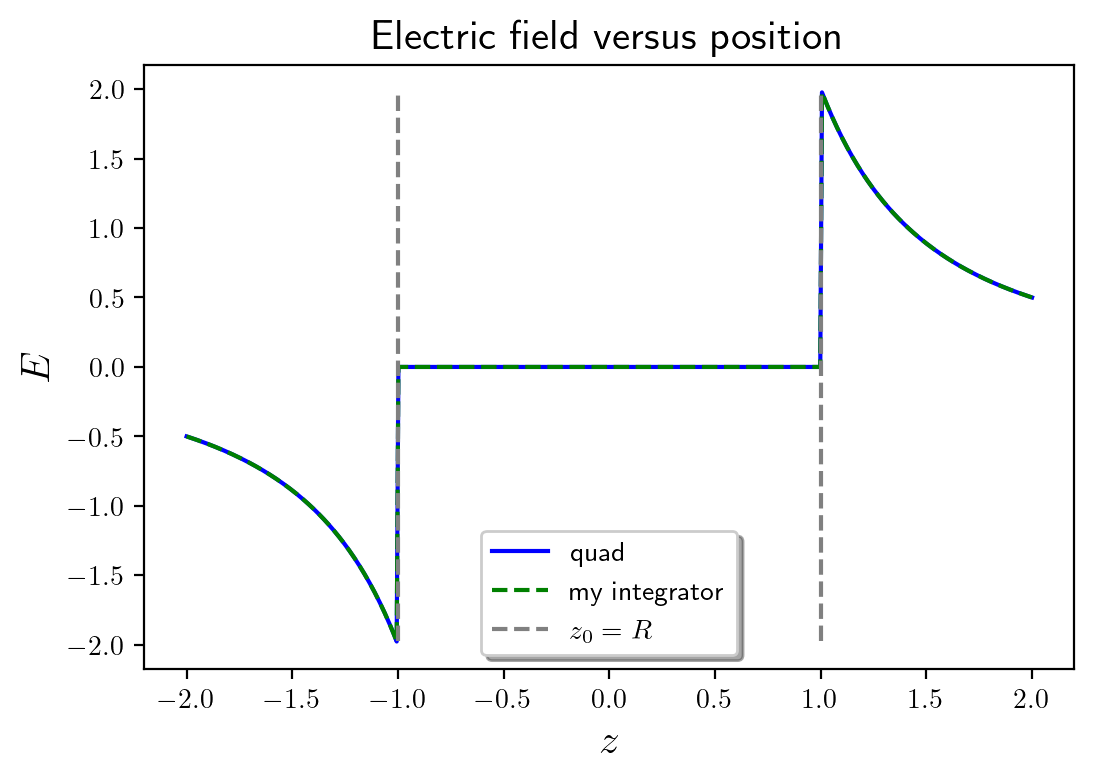

In [4]:
plt.plot(z_array,E_array_quad,color='blue',label='quad')
plt.plot(z_array,E_array,color='green',label='my integrator',ls='--')

plt.plot([-R,-R],[E_array.min(),E_array.max()],ls='--',color='gray',label='$z_0=R$')
plt.plot([R,R],[E_array.min(),E_array.max()],ls='--',color='gray')
plt.xlabel('$z$',fontsize=15)
plt.ylabel('$E$',fontsize=15)
plt.title('Electric field versus position',fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

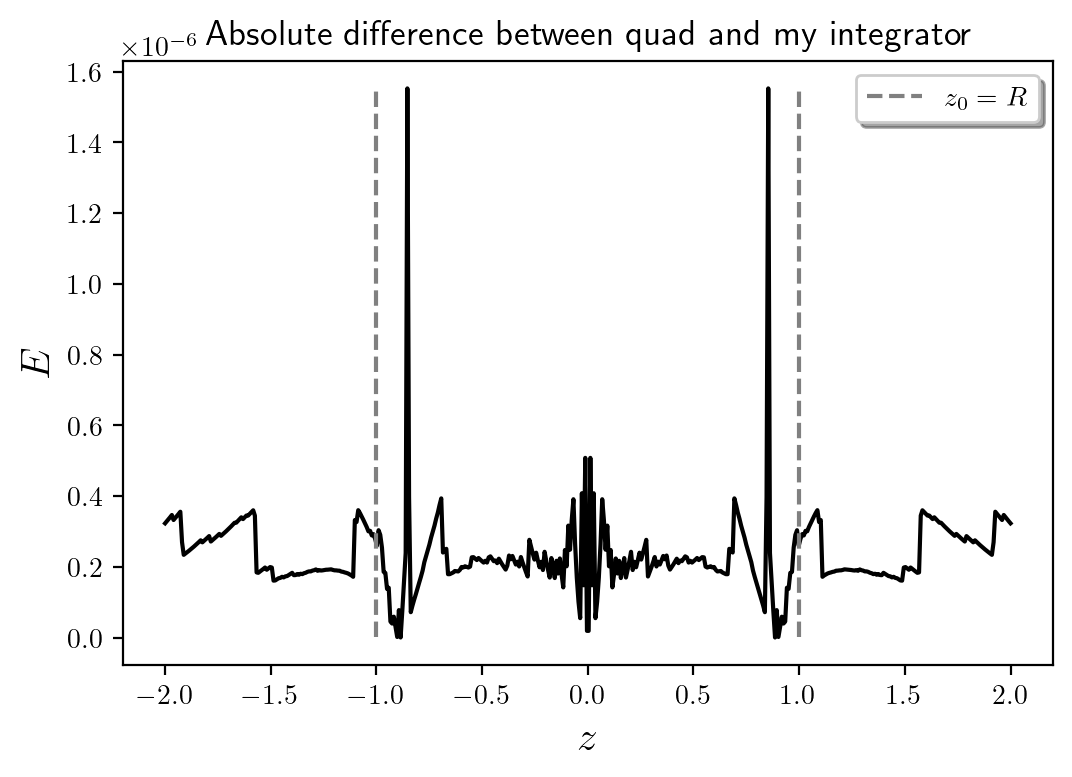

In [5]:
plt.plot(z_array,np.abs(E_array_quad-E_array),color='black')
plt.plot([-R,-R],[np.abs(E_array_quad-E_array).min(),np.abs(E_array_quad-E_array).max()],ls='--',color='gray',label='$z_0=R$')
plt.plot([R,R],[np.abs(E_array_quad-E_array).min(),np.abs(E_array_quad-E_array).max()],ls='--',color='gray')
plt.xlabel('$z$',fontsize=15)
plt.ylabel('$E$',fontsize=15)
plt.title('Absolute difference between quad and my integrator',fontsize=13)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

We see that quad and my integrator agree everywhere, and the absolute difference with respect to quad is less that $10^{-5}$ which is what I requested as tollerance. Now I check that my integrator indeed breaks down at $z=R$, and that quad manages to work around the singularity in the integrand

In [6]:
f = gen_f(R,R)

# Trying with my integrator
try:
    my_integrate(f,-R,R,1e-2)
except Exception as exception:
    print(exception)
    
# Trying with quad
print('Integral as calculated by quad:', integrate.quad(f,-R,R)[0])

maximum recursion depth exceeded while calling a Python object
Integral as calculated by quad: 0.9999999999999938


C:\Users\Guill\Anaconda3\envs\ml_pytorch\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Now as a fix for this, I show that we can integrate not from $z'=-R$ to $z'=R$ but rather from $z'$ very close to $-R$ to $z'$ very close to $R$. So here I use my integrator in this way and recreate the integral value of ~$1$ obtained by quad.

In [7]:
f = gen_f(R,R)

print(my_integrate(f,-R+R*1e-10,R-R*1e-10,1e-5))

0.9999931992016304


This is accurate to ~$10^{-5}$ which is what I requested as tolerance from my integrator.

# Q2

I start by adapting the integrator from last question so that it keeps memory of every evaluation of $f$ it does. Whether to make use of the memory is passed as an extra argument "use_memory". I then integrate $f(x)=\cos(x)$ from $-\pi/2$ to $\pi/2$ with a tolrance of $10^{-10}$ and observed how many function calls are saved

In [8]:
def my_integrate(f,a,b,tol,extra=None,use_memory=True):
    # If the memory is empty, initiate it, else retrieve it
    if not extra:
        x_memory = []
        y_memory = []
    else:
        x_memory = extra[0]
        y_memory = extra[1]
        
    # Integrating with 3 point and 5 point Simpson's rule
    x = np.linspace(a,b,5)
    y = np.zeros_like(x)
    
    # Using memory to get y values corresponding to this array of x, 
    # and adding new evaluations to memory
    for i in range(len(x)):
        if x[i] in x_memory:
            y[i] = y_memory[x_memory.index(x[i])]
        else:
            y[i] = f(x[i])
            if use_memory:
                x_memory.append(x[i])
                y_memory.append(y[i])
            # if memory usage is off, still append a nan to the memory 
            # because this is how I keep track of # of function calls
            else:
                x_memory.append(np.nan)
                y_memory.append(np.nan)
            
    # Integrating with 3 point and 5 point Simpson's rule
    int_3 = (x[-1]-x[0])/6*(y[0]+4*y[2]+y[4])
    int_5 = (x[-1]-x[0])/12*(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])
    
    # if approximate error < tol, return the result, else split the 
    # integral in 2
    if np.abs(int_3-int_5)<tol:
        return int_5
    int_left = my_integrate(f,a,(a+b)/2,tol/2,[x_memory,y_memory],use_memory=use_memory)
    int_right = my_integrate(f,(a+b)/2,b,tol/2,[x_memory,y_memory],use_memory=use_memory)
    
    # Printing number of function calls at the end
    if not extra:
        print('number of function calls:',len(x_memory))
    return (int_left + int_right)

In [9]:
f = np.cos
print(my_integrate(f,-np.pi/2,np.pi/2,1e-10,use_memory=True))
print(my_integrate(f,-np.pi/2,np.pi/2,1e-10,use_memory=False))

number of function calls: 1011
2.0000000000015197
number of function calls: 2335
2.0000000000015197


So we see that the number of calls was reduced in this case by a factor of $\sim2.3$ which is great.

# Q3

I fit a Chebyshev polynomial to $\log_2(x)$, $5000$ points and $100$ coefficients. 

I use the fact that the Chevyshev polymials are bounded by $-1$ and $1$ to say that the error on the Chebyshev polynomial evaluated at these $5000$ points is less than the sum of coefficients which I cut out. For that to work it needs to be clear that the coefficients drop fast enough that their sum can be approximated by the $~100$ coefficients that will be cut off. Also this doesn't say anything about the error at points in between the $5000$ selected points, but we'll assume that the interpolation is good.

So first I do the Chebyshev fit:

In [10]:
npts = 5000
order = 100
x = (np.linspace(0.5,1,npts)-0.75)*4
y = np.log2(np.linspace(0.5,1,npts))
coeffs = np.polynomial.chebyshev.chebfit(x, y, order)

Now I plot the coefficients to see that they drop very quickly

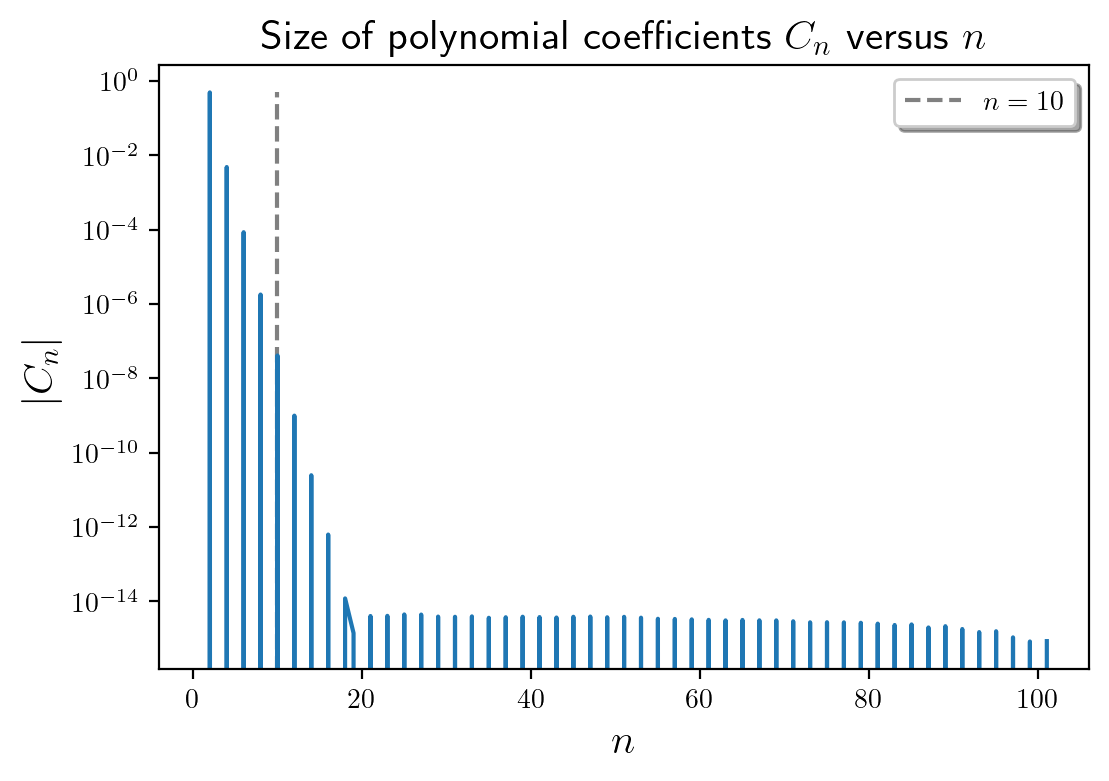

In [11]:
plt.plot([10,10],[coeffs.min(),coeffs.max()],ls='--',color='gray',label='$n=10$')
plt.plot(np.arange(1,102),coeffs)
plt.xlabel('$n$',fontsize=15)
plt.ylabel('$|C_n|$',fontsize=15)
plt.title('Size of polynomial coefficients $C_n$ versus $n$',fontsize=15)
plt.yscale('log')
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

If we cut off the coefficients $C_{10}$ and beyond, we get that the sum of the cut off coefficients is less than the demanded tolerance of $10^{-6}$ (see line of code below), and we see from the plot above that the sum of the $C_n$ from $C_{10}$ to $C_{100}$ should approximate the sum of all coefficients beyond $C_{10}$ very well. 

In [12]:
# Sum of C_n starting at C_10
np.sum(np.abs(coeffs[10:]))

7.559071381489694e-09

So we can keep the coefficients $C_0$ to $C_9$ only.

Here I test the resulting 9th order Chebyshev polynomial by evaluating $log_2(0.75)$

In [13]:
x0 = 0.75
x0_ = (x0-0.75)*4

truth = np.log2(x0)
approx = np.polynomial.chebyshev.chebval(x0_,coeffs[0:10])
print('truth',truth)
print('approx',approx)
print('error',np.abs(truth-approx))

truth -0.4150374992788438
approx -0.4150375055043163
error 6.225472470866578e-09


The error is indeed less that $10^{-6}$.

Now I also plot the approximated $log_2$ and the true $log_2$, as well as the error, over the entire approximated range, to make sure that this really worked

In [14]:
x = np.linspace(0.5,1,1000)
x_ = (x-0.75)*4

truth = np.log2(x)
approx = np.polynomial.chebyshev.chebval(x_,coeffs[0:10])

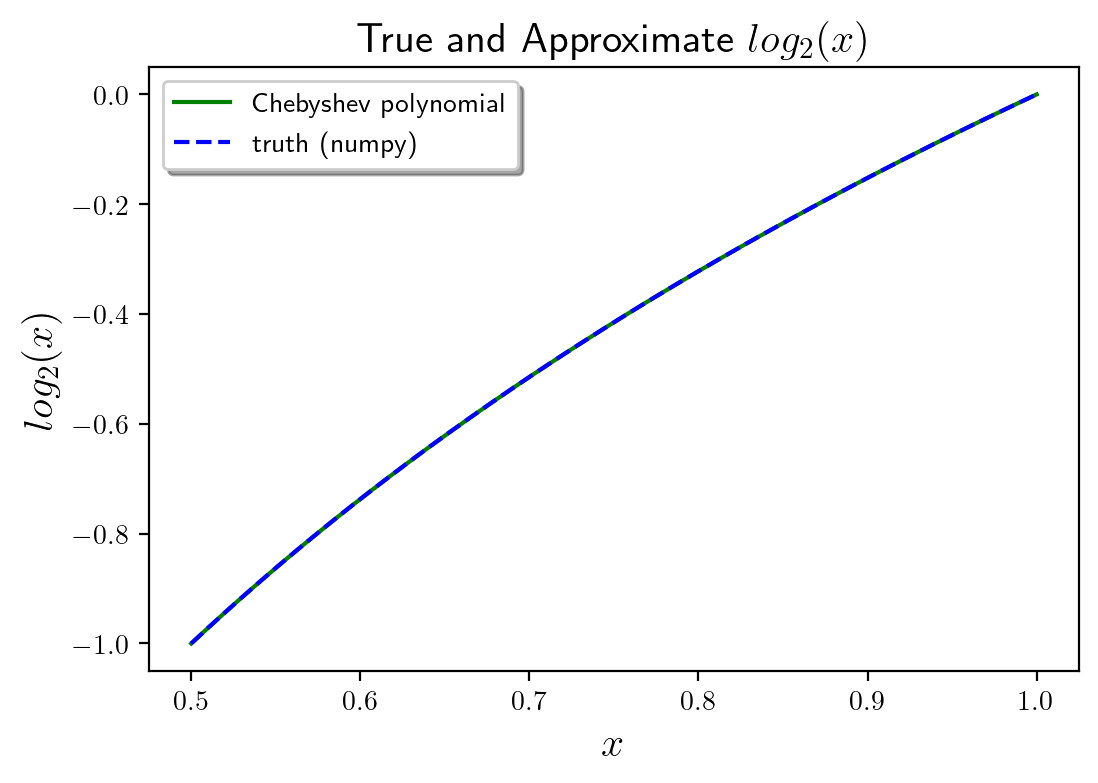

In [15]:
plt.plot(x,approx,color='green',label='Chebyshev polynomial')
plt.plot(x,truth,color='blue',label='truth (numpy)',ls='--')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('$log_2(x)$',fontsize=15)
plt.title('True and Approximate $log_2(x)$',fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

Text(0.5, 1.0, 'Absolute error on Approximate $log_2(x)$')

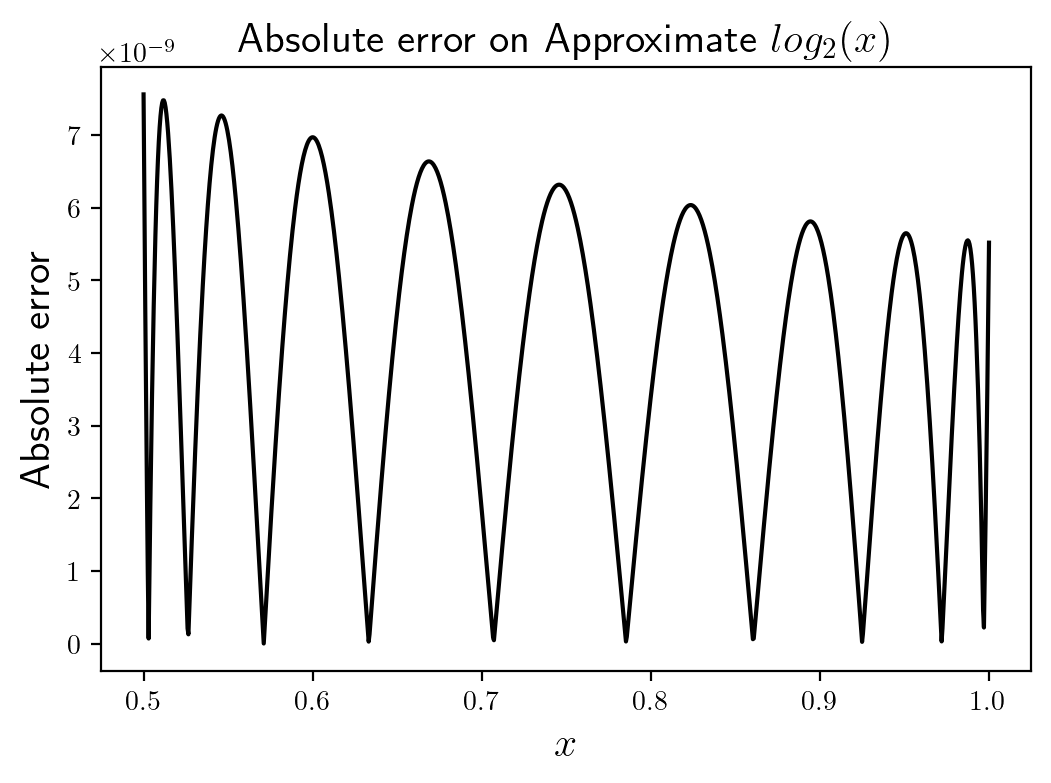

In [16]:
plt.plot(x,np.abs(approx-truth),color='black')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('Absolute error',fontsize=15)
plt.title('Absolute error on Approximate $log_2(x)$',fontsize=15)

So we see that the error is indeed below $10^{-6}$ across the entire interval as desired.

Now we make a $\log_2(x)$ function that can take in any positive number $x$. The idea is to write $x$ as it's mantissa and twos exponent decomposition, ie,
\begin{align}
    x = m2^n
\end{align}
where for a positive number the mantissa $m$ satisfies $0.5<m<1$ and $n$ is the exponent. But then
\begin{align}
    \log_2(x)&=\log_2(m) + n\log_2(2)\\
    &=\log_2(m)+n
\end{align}
and now we just have to use the $log_2$ chebyshev coefficients found before for $0.5<x<1$ and we get our result. In what follows I write a function that does this and test it against numpy's np.log2

In [17]:
def gen_log2(cheb_coeffs):
    # generate a log2 function given cheb coefficients
    def mylog2(x):
        # decompose x into mantissa and exponent
        m,n = np.frexp(x)
        # map mantissa to the domain of cheb polynomials
        m_ = (m-0.75)*4
        # compute log2(x) using cheb coefficients
        y = np.polynomial.chebyshev.chebval(m_,coeffs[0:10])+n
        return y
    return mylog2

In [18]:
x = np.linspace(2**(-3),2**3,1000)
mylog2 = gen_log2(coeffs)

truth = np.log2(x)
approx = mylog2(x)

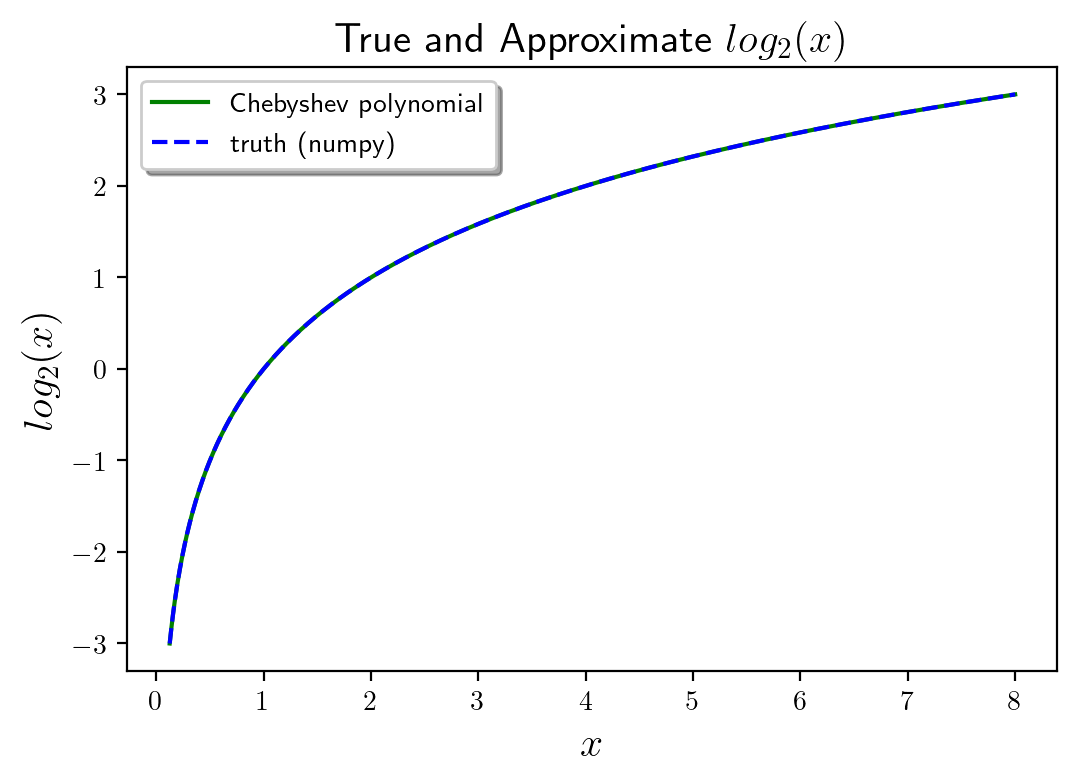

In [19]:
plt.plot(x,approx,color='green',label='Chebyshev polynomial')
plt.plot(x,truth,color='blue',label='truth (numpy)',ls='--')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('$log_2(x)$',fontsize=15)
plt.title('True and Approximate $log_2(x)$',fontsize=15)
plt.legend(loc=0,frameon=True,shadow=True,fontsize=10)

Text(0.5, 1.0, 'Absolute error on Approximate $log_2(x)$')

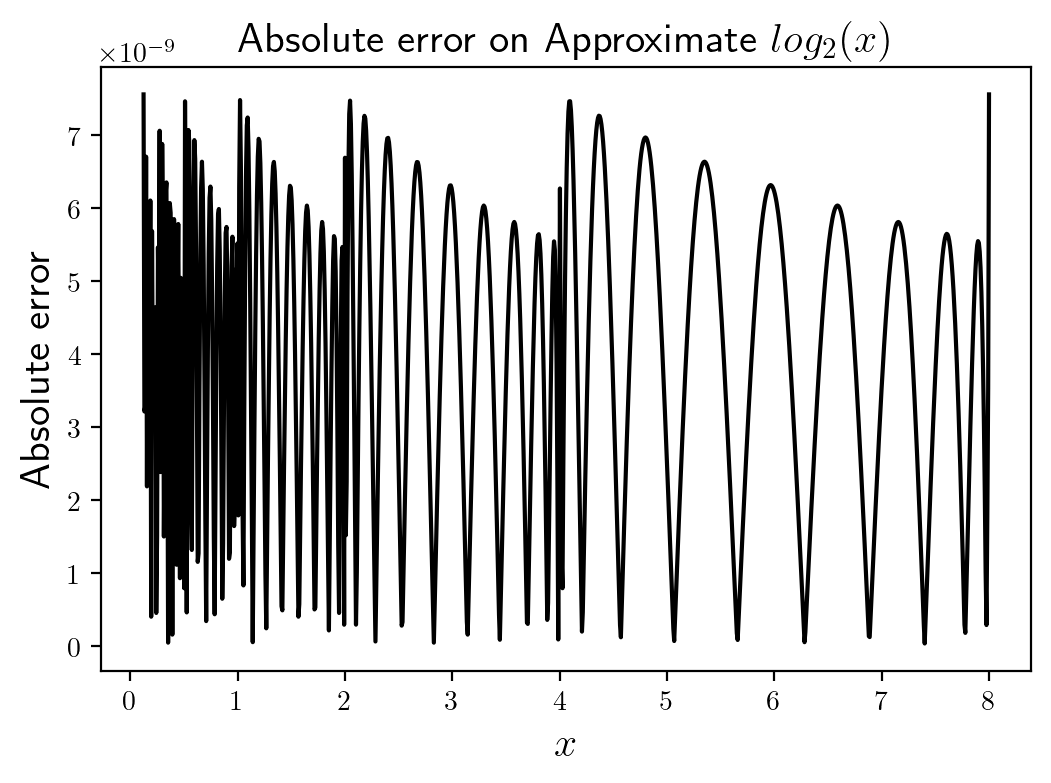

In [20]:
plt.plot(x,np.abs(approx-truth),color='black')
plt.xlabel('$x$',fontsize=15)
plt.ylabel('Absolute error',fontsize=15)
plt.title('Absolute error on Approximate $log_2(x)$',fontsize=15)

So we see that the error is indeed below $10^{-6}$ across the entire interval.